# Análise simples

In [1]:
#Descrição: Um programa para análise de sentimentos que recebe textos do Twitter usando Python

## Importando os tweets

In [1]:
#Pacotes
import tweepy
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd #
import numpy as np #Linear algebra
import re #Regular expressions
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
#Pegando os dados
log = pd.read_csv("Login twitter.csv")

In [4]:
#Twitter API credentials
consumerKey = log['API Key'][0]
consumerSecret = log['API Key'][1]
bearerToken = log['API Key'][2]
accessToken = log['API Key'][3]
accessTrokenSecret = log['API Key'][4]

In [5]:
client = tweepy.Client(bearer_token = bearerToken)

In [6]:
#Criando objeto de autenticação
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)

#Set-ando o access token e o access token secret
authenticate.set_access_token(accessToken, accessTrokenSecret)

#Criando o objeto API enquanto é passada a informação de autenticação
api = tweepy.API(authenticate, wait_on_rate_limit = True)

In [ ]:
#posts = client.search_recent_tweets(query = "BillGates", max_results = 100) #As últimas 100 menções ao BillGates

In [61]:
searchId = 50393960 #"billgates"

start_time = "2020-12-01T00:00:00Z"
end_time = "2022-03-10T00:00:00Z"

In [62]:
#https://docs.tweepy.org/en/stable/client.html?highlight=get_users_tweets#tweepy.Client.get_users_tweets
#Aqui extraimos apenas os tweets feitos pelo usuário, ignorando retweets e replies. (acabei nao ignorando)
posts = client.get_users_tweets(id = searchId,
                                start_time = start_time,
                                end_time = end_time, 
                                #exclude = ["retweets","replies"], 
                                #expansions = 'author_id', 
                                max_results = 100,
                                tweet_fields = ["created_at", "text", "source"],
                                user_fields = ["name", "username", "location", "verified", "description"])

In [68]:
#Para verificar todas as informações sobre o tweets posts.data[n].data, onde n=0 é o tweet mais recente

#Imprimir os últimos 5 tweets da conta
print("Mostrando os 5 tweets mais recentes: \n")
for n in range(0,5):
    print(str(n+1) + ') ' + posts.data[n].text + '\n')

Mostrando os 5 tweets mais recentes: 

1) In a crisis, we can always look for the helpers—the people who are putting their lives on the line to aid refugees and victims of the invasion—and support them. I’m proud to support the UN’s refugee agency and urge the global community to do the same. https://t.co/5fkRU6UmCK

2) It’s gut-wrenching to see the people of Ukraine suffering so much. The world feels especially heavy right now, with each day bringing news of families torn apart in Afghanistan, Ukraine, and so many other places.

3) I’m optimistic about our ability to prevent the next pandemic. We have learned so much from COVID, and the innovations have been tremendous. https://t.co/QDfUnEbYeJ

4) The Global Fund is one of the best investments in global health. Fully funding its programs for the next 3 years is critical to ending HIV, TB, and malaria while helping ensure COVID-19 is the last pandemic. https://t.co/t4N4LhlaUb

5) At the end of the day, Paul’s most lasting impact can be

## Pré-Processamento

### Criando um data frame

In [69]:
#Criando um DataFrame com uma coluna chamada Tweets
df = pd.DataFrame([posts.data[n].text for n in range(0,len(posts.data))], columns=['Tweets'])

#Mostrar as primeiras 5 linhas
df.head()

,Tweets
0,"In a crisis, we can always look for the helper..."
1,It’s gut-wrenching to see the people of Ukrain...
2,I’m optimistic about our ability to prevent th...
3,The Global Fund is one of the best investments...
4,"At the end of the day, Paul’s most lasting imp..."


### Limpando os dados

In [71]:
#Limpando o texto: encontramos urls, @ e # no conjunto de dados e essas informações precisar ser removidas
#para que a análise faça sentido

#Criando uma função para limpar os tweets
def limpTxt(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #remove menções @
    text = re.sub(r'#', '', text) #remove as #
    text = re.sub(r'RT[\s]+', '', text) #remove retweets (nesse caso não extraimos tweets com isso, mas é bom mostrar)
    text = re.sub(r'https?:\/\/\S+', '', text) #remove a url/hyperlink
    
    return text

#Aplicando a função para limpar os tweets
df['Tweets'] = df['Tweets'].apply(limpTxt)

#Mostrando o texto limpo
df['Tweets'][0] #Aqui vemos que a url foi removida.

'In a crisis, we can always look for the helpers—the people who are putting their lives on the line to aid refugees and victims of the invasion—and support them. I’m proud to support the UN’s refugee agency and urge the global community to do the same. '

### Adicionando subjetividade e polaridade ao data frame

In [72]:
#Criando uma função para obter a subjetividade
def obterSubjetividade(text):
    return TextBlob(text).sentiment.subjectivity

#Criando uma função para obter a polaridade (diz quão positivo ou negativo o texto é)
def obterPolaridade(text):
    return TextBlob(text).sentiment.polarity

#Criando duas novas colunas no DataFrame
df['Subjetividade'] = df['Tweets'].apply(obterSubjetividade)
df['Polaridade'] = df['Tweets'].apply(obterPolaridade)

#Mostrando o novo DataFrame com as novas colunas
df

,Tweets,Subjetividade,Polaridade
0,"In a crisis, we can always look for the helper...",0.375000,0.266667
1,It’s gut-wrenching to see the people of Ukrain...,0.522143,0.092143
2,I’m optimistic about our ability to prevent th...,0.400000,0.177778
3,The Global Fund is one of the best investments...,0.194444,0.166667
4,"At the end of the day, Paul’s most lasting imp...",0.425000,0.325000
...,...,...,...
95,2021 saw incredible innovation in health and c...,0.537500,0.443750
96,I love the message in ’s new book that in orde...,0.451515,0.145455
97,The bipartisan Infrastructure Investment and J...,0.500000,0.300000
98,Data sharing and global collaboration move us ...,0.227273,0.068182


## Análise exploratória

### Núvem de palavras

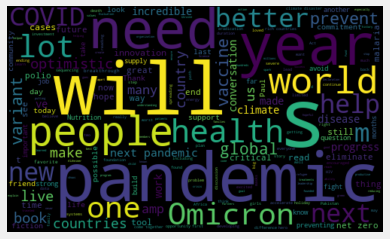

In [73]:
#Plotando a nuvem de palavras
todasPalavras = ' '.join([twts for twts in df['Tweets']] )
nuvemPalavras = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(todasPalavras)

plt.imshow(nuvemPalavras, interpolation= 'bilinear')
plt.axis('off')
plt.show()

### Criando um score para as mensagens

In [91]:
#Criando uma função para computar as análises positivas, negativas e neutras
def obterAnalise(score):
    if score < 0:
        return 'Negativo'
    elif score == 0:
        return 'Neutro'
    else:
        return 'Positivo'

#Criando uma coluna com o score
df['Analise'] = df['Polaridade'].apply(obterAnalise)

#Mostrando o df
df

,Tweets,Subjetividade,Polaridade,Analise
0,"In a crisis, we can always look for the helper...",0.375000,0.266667,Positivo
1,It’s gut-wrenching to see the people of Ukrain...,0.522143,0.092143,Positivo
2,I’m optimistic about our ability to prevent th...,0.400000,0.177778,Positivo
3,The Global Fund is one of the best investments...,0.194444,0.166667,Positivo
4,"At the end of the day, Paul’s most lasting imp...",0.425000,0.325000,Positivo
...,...,...,...,...
95,2021 saw incredible innovation in health and c...,0.537500,0.443750,Positivo
96,I love the message in ’s new book that in orde...,0.451515,0.145455,Positivo
97,The bipartisan Infrastructure Investment and J...,0.500000,0.300000,Positivo
98,Data sharing and global collaboration move us ...,0.227273,0.068182,Positivo


In [92]:
#Imprimir todos os tweets positivos
j=1
sortedDf = df.sort_values(by=['Polaridade'])
for i in range(0,sortedDf.shape[0]):
    if (sortedDf['Analise'][i] == 'Positivo'):
        print(str(j) + ') ' + sortedDf['Tweets'][i])
        print()
        j = j+1

1) In a crisis, we can always look for the helpers—the people who are putting their lives on the line to aid refugees and victims of the invasion—and support them. I’m proud to support the UN’s refugee agency and urge the global community to do the same. 

2) It’s gut-wrenching to see the people of Ukraine suffering so much. The world feels especially heavy right now, with each day bringing news of families torn apart in Afghanistan, Ukraine, and so many other places.

3) I’m optimistic about our ability to prevent the next pandemic. We have learned so much from COVID, and the innovations have been tremendous. 

4) The Global Fund is one of the best investments in global health. Fully funding its programs for the next 3 years is critical to ending HIV, TB, and malaria while helping ensure COVID-19 is the last pandemic. 

5) At the end of the day, Paul’s most lasting impact can be found in the patients he loved so dearly—all of the people who are alive today because he dedicated his lif

In [93]:
#Imprimir todos os tweets negativos
j=1
sortedDf = df.sort_values(by=['Polaridade'],ascending=False)
for i in range(0,sortedDf.shape[0]):
    if (sortedDf['Analise'][i] == 'Negativo'):
        print(str(j) + ') ' + sortedDf['Tweets'][i])
        print()
        j = j+1

1) What a devastating loss. Paul is a hero, and I was fortunate to call him a friend. I have never known anyone who was more passionate about reducing the world’s worst inequities in health—or who did more to live by his values. 

2) One person’s act of bravery can spark dramatic change in hundreds of lives. ’s story is a powerful example. 

3) I wholeheartedly agree with Larry's view that all companies need to be actively preparing for their net zero transition - shareholders, employees, customers, communities, and regulators expect it. 

4) The omicron surge is an unfortunate reminder that the only way to eliminate the threat of COVID-19 somewhere is to eliminate it everywhere. That’s why  is joining  to renew our investment in . 

5) ICYMI here’s a recap of my conversation with . We chatted about this pandemic, how to prevent the next one, and a few things in between. 

6) :     So tough question: where do you think SARS-CoV-2 came from? What data do you want to see? An…

7)     Peo

In [94]:
#Imprimir todos os tweets neutros
j=1
sortedDf = df.sort_values(by=['Polaridade'],ascending=False)
for i in range(0,sortedDf.shape[0]):
    if (sortedDf['Analise'][i] == 'Neutro'):
        print(str(j) + ') ' + sortedDf['Tweets'][i])
        print()
        j = j+1

1) Paul was never happier than when he was caring for patients in one of the clinics he helped create. My heart goes out to his family and friends, his colleagues, and all the people whose lives he touched.

2) Thank you  for the productive discussions on the steps being taken in Pakistan to eliminate polio. I’m encouraged by the country’s commitment to eradication and am optimistic that if everyone remains vigilant, we can endpolio. 

3) I believe that COVID-19 can be the last pandemic. ‘How to Prevent the Next Pandemic’ will explain why. 

4) Science fiction can help expand our understanding by pushing the limits of what is possible. 

5) The Institute for Health Metrics and Evaluation _UW found that improving trust could make a critical difference when it comes to ending this pandemic and preventing the next one. 

6) Strengthening health systems is critical to preventing future pandemics.  shows how countries like Senegal and India are building resilient health infrastructures. 

7

### Visualizando os dados

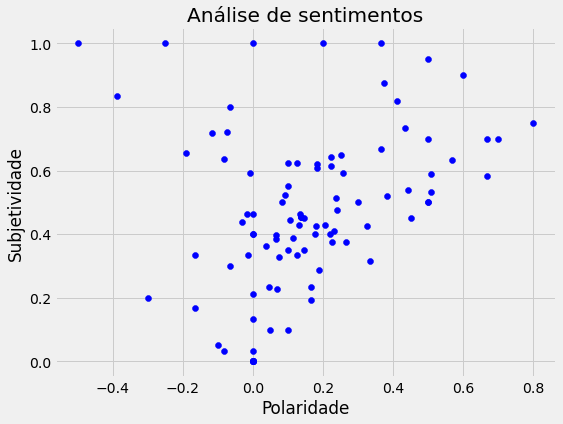

In [95]:
#Plotando a Polaridade e Subjetividade
plt.figure(figsize=(8,6))
for i in range(0,df.shape[0]):
    plt.scatter(df['Polaridade'][i],df['Subjetividade'][i],color='Blue')
    
plt.title('Análise de sentimentos')
plt.xlabel('Polaridade')
plt.ylabel('Subjetividade')
plt.show()

In [96]:
#Obter a porcentagem de tweets positivos
ptweets = df[df['Analise'] == 'Positivo']
ptweets = ptweets['Tweets']

round(ptweets.shape[0]/df.shape[0], 2)

0.66

In [97]:
ntweets = df[df['Analise'] == 'Negativo']
ntweets = ntweets['Tweets']

round(ntweets.shape[0]/df.shape[0], 2)

0.18

In [98]:
xtweets = df[df['Analise'] == 'Neutro']
xtweets = xtweets['Tweets']

round(xtweets.shape[0]/df.shape[0], 2)

0.16

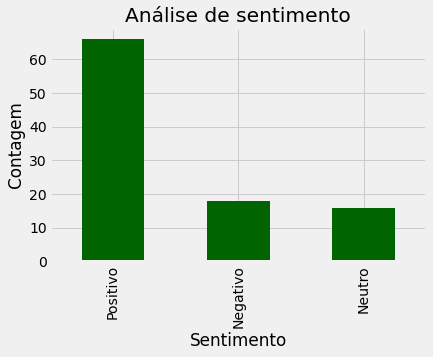

In [101]:
#Mostrando a contagem 
df['Analise'].value_counts()

#Plotando e visualizando a contagem
plt.title('Análise de sentimento')
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
df['Analise'].value_counts().plot(kind='bar',color='darkgreen')
plt.show()